In [520]:
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [521]:
from numpy.polynomial.hermite_e import hermegauss
from itertools import product

In [522]:
#p is pth Hermite Poly. n is order of Multivariate Normal Dist
p = 4
n = 1

unit_sigma_points, hermite_weights = hermegauss(p)
hermite_weights /= np.sum(hermite_weights)

unit_sigma_points = np.array(list(product(*(unit_sigma_points for _ in range(n))))).T  # Cartesian product
hermite_weights = np.array(list(product(*(hermite_weights for _ in range(n))))).prod(axis=1)

Trying for n = 1 

In [523]:
#matrix of state=space model parameters
#A = np.array([[1., 2, 1e-10],[2, 3, 1e-10],[1e-10, 1e-10, 4]])
A = 2.5

In [524]:
# mu_k = np.array([[2.0, 1.0, 3]])
# P_k = np.eye(3)
# P_k = np.linalg.cholesky(P_k)
# xk_dist = tfd.MultivariateNormalDiag(loc = mu_k, scale_diag = P_k)
#xk_dist = tfd.Normal(loc = mu_k, scale=P_k)

mu_k = 2
P_k = 2
xk_dist = tfd.Normal(loc = mu_k, scale=P_k)

In [525]:
# sigma_xk = P_k @ unit_sigma_points + mu_k.T
sigma_xk = P_k * unit_sigma_points + mu_k

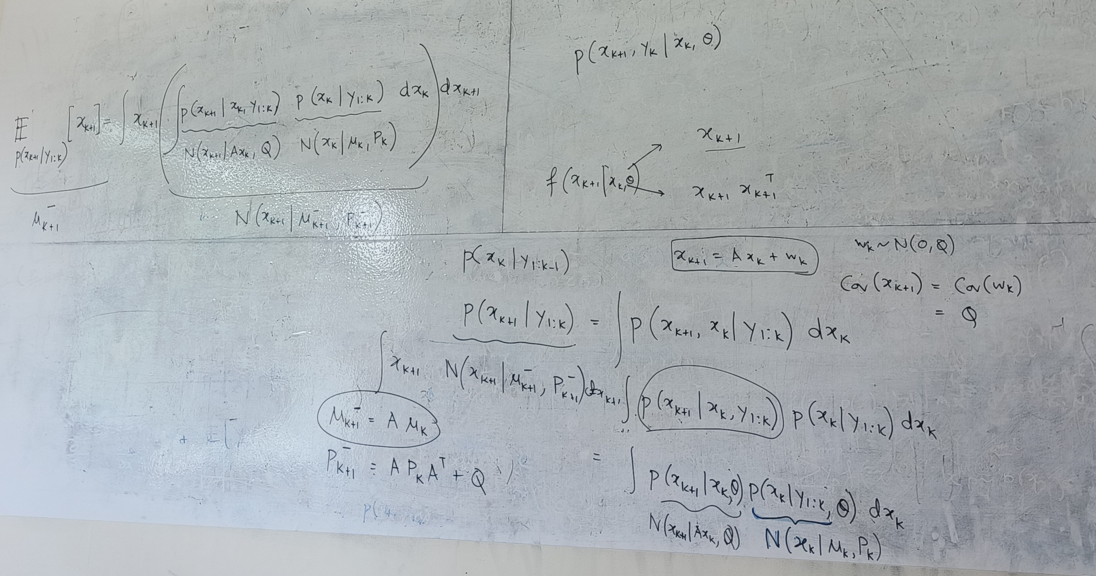

$I = \int p(x_{k+1}|x_k, y_{1:k}) \cdot \text{Normal}(x_k|\mu_k, P_k) dx_k \approx \sum W_1^j p(x_{k+1}|\xi_k^j, y_{1:k}) = N(x_{k+1}|A\xi_1, Q W_1) $


$ \int x_{k+1} N(x_{k+1}|A\xi_1, Q W_1)dx_{k+1} \approx \sum W_2 \xi_2 $ where $\xi_2 $ are sigma points at mean $A\xi_1$ and sd=  $Q W_1$

$x_{k+1} = A x_k + w_k$ where $w_k$ ~ $Normal(0,Q)$ 


In [526]:
# mu_k1 = mu_k @ A 
# Q_k1 = np.eye(3)

# xk1_dist = tfd.MultivariateNormalDiag(loc = mu_k1, scale_diag = Q_k1)

In [527]:
mu_k1 = A * sigma_xk
Q1 = 1.5
Q = Q1 * hermite_weights #because N(0,a)*b  = N(0,a*b)
xk1_dist = tfd.Normal(loc = mu_k1, scale = Q)
sigma_xk1 = unit_sigma_points* Q + mu_k1

In [528]:
res = np.sum(hermite_weights * sigma_xk1)
res

5.000000000000001

Which is equal to the mean $A \mu_k$ :

In [529]:
A * mu_k

5.0

(x-E(x))^2 instead of x in the final step.

In [530]:
s = (sigma_xk1 - res)**2
s.shape

(1, 4)

In [532]:
aa = np.einsum('i,ji->i', hermite_weights, s)

In [533]:
np.sum(aa)

28.984374999999986

In [536]:
res_sd = np.dot(hermite_weights , s.T)
res_sd

array([28.984375])

In [537]:
cf_var = A * P_k**2 * A   + Q1**2
cf_var

27.25

In [538]:
error = (res_sd-cf_var)/(0.01*cf_var)
print(error, "%")

[6.3646789] %


P_k^2 and Q1^2 represent variances (not sd)

**Now for Multivariate case**

In [498]:
#p is pth Hermite Poly. n is order of Multivariate Normal Dist
p = 4
n = 3

unit_sigma_points, hermite_weights = hermegauss(p)
hermite_weights /= np.sum(hermite_weights)

unit_sigma_points = np.array(list(product(*(unit_sigma_points for _ in range(n))))).T  # Cartesian product
hermite_weights = np.array(list(product(*(hermite_weights for _ in range(n))))).prod(axis=1)

In [499]:
mu_k = np.array([[20, 1.0, 13]])
P_k = np.diag([1,2.,9])
LP_k = np.linalg.cholesky(P_k)
xk_dist = tfd.MultivariateNormalDiag(loc = mu_k, scale_diag = LP_k)
sigma_xk = LP_k @ unit_sigma_points + mu_k.T

In [500]:
A = np.array([[1, 9, 1e-10],[2, 1, 1e-10],[1e-10, 1e-10, 24]])

mu_k1 = A @ sigma_xk          
Q_k1 = np.diag([2,1,8])
LQ_k1 = np.linalg.cholesky(Q_k1)


In [501]:
Q_mat = np.einsum('ik, j -> ikj', LQ_k1, hermite_weights)

In [502]:
xk1_dist = tfd.MultivariateNormalDiag(loc = mu_k1, scale_diag = Q_mat)

In [503]:
scaled_sig_2 = tf.einsum('ijk,jk->jk',Q_mat , unit_sigma_points) + mu_k1

In [504]:
res = np.einsum('i,ji->j ',hermite_weights, scaled_sig_2)
res = res.reshape(res.shape[0],1)
res

array([[ 29.],
       [ 41.],
       [312.]])

In [505]:
closed_form = A @ mu_k.T
closed_form

array([[ 29.],
       [ 41.],
       [312.]])

In [506]:
s = (scaled_sig_2 - res)
s.shape

TensorShape([3, 64])

In [507]:
s1 = tf.einsum('ij,kj-> ikj ', s, s)

In [508]:
s1.shape

TensorShape([3, 3, 64])

In [509]:
r1 = tf.einsum('i, jki -> jk', hermite_weights, s1)
r1

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[1.63130086e+02, 2.06751888e+01, 2.35430293e-08],
       [2.06751888e+01, 6.12642370e+00, 2.20429484e-08],
       [2.35430293e-08, 2.20429484e-08, 5.20170697e+03]])>

In [515]:
closed_f = (A @ P_k @ A.T + Q_k1)
closed_f

array([[1.650e+02, 2.000e+01, 2.350e-08],
       [2.000e+01, 7.000e+00, 2.200e-08],
       [2.350e-08, 2.200e-08, 5.192e+03]])

#P_k, Q_k1 are COVARIANCE Matrices (Not Cholesky Factors)

Non Diagonal Matrices:

In [542]:
#p is pth Hermite Poly. n is order of Multivariate Normal Dist
p = 4
n = 3

unit_sigma_points, hermite_weights = hermegauss(p)
hermite_weights /= np.sum(hermite_weights)

unit_sigma_points = np.array(list(product(*(unit_sigma_points for _ in range(n))))).T  # Cartesian product
hermite_weights = np.array(list(product(*(hermite_weights for _ in range(n))))).prod(axis=1)

mu_k = np.array([[20, 1.0, 13]])
P_k = np.array([[4, -1, 1],
              [-1, 5, 2],
              [1, 2, 3]])
LP_k = np.linalg.cholesky(P_k)
xk_dist = tfd.MultivariateNormalDiag(loc = mu_k, scale_diag = LP_k)
sigma_xk = LP_k @ unit_sigma_points + mu_k.T

A = np.array([[11, 9, 1e-10],[2.5, 1, 1e-10],[1e-10, 10, 24]])

mu_k1 = A @ sigma_xk          
Q_k1 = np.array([[9, 3, -2],
              [3, 6, 1],
              [-2, 1, 5]])
LQ_k1 = np.linalg.cholesky(Q_k1)


Q_mat = np.einsum('ik, j -> ikj', LQ_k1, hermite_weights)

xk1_dist = tfd.MultivariateNormalDiag(loc = mu_k1, scale_diag = Q_mat)

scaled_sig_2 = tf.einsum('ijk,jk->jk',Q_mat , unit_sigma_points) + mu_k1

res = np.einsum('i,ji->j ',hermite_weights, scaled_sig_2)
res = res.reshape(res.shape[0],1)


closed_form = A @ mu_k.T


s = (scaled_sig_2 - res)


s1 = tf.einsum('ij,kj-> ikj ', s, s)


r1 = tf.einsum('i, jki -> jk', hermite_weights, s1)

closed_f = (A @ P_k @ A.T + Q_k1)


In [549]:
res #Predicted mean

array([[229.],
       [ 51.],
       [322.]])

In [550]:
closed_form #actual

array([[229.],
       [ 51.],
       [322.]])

In [551]:
r1  #predicted cov

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[ 696.10434752,  124.68926936, 1037.01273149],
       [ 124.68926936,   25.59660268,  139.02643535],
       [1037.01273149,  139.02643535, 3193.42202914]])>

In [552]:
closed_f #actual

array([[ 700.00000001,  124.5       , 1034.00000001],
       [ 124.5       ,   31.        ,  134.00000001],
       [1034.00000001,  134.00000001, 3193.        ]])

In [548]:
mse = np.sqrt(np.mean((r1-closed_f)**2))
mse

3.5481727965937817